In [ ]:
#Gaussian Process 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def rbf_kernel_1d(x, y, length_scale=0.2, sigma=1.0):
    """
    RBF (squared exponential) kernel for 1D inputs.

    Parameters:
    -----------
    x : array of shape (N,)
    y : array of shape (M,)
    length_scale : float
        Length scale of the RBF kernel.
    sigma : float
        Overall variance (vertical scale).

    Returns:
    --------
    K : array of shape (N, M)
        Covariance matrix between points in x and y.
    """
    # Expand x,y into column and row vectors
    x = x[:, None]  # shape (N, 1)
    y = y[None, :]  # shape (1, M)
    sqdist = (x - y)**2
    K = sigma**2 * np.exp(-0.5 * sqdist / length_scale**2)
    return K

def rbf_kernel_2d(coords1, coords2, length_scale=0.2, sigma=1.0):
    """
    RBF kernel for 2D coordinates (e.g., points in (x,y)).

    Parameters:
    -----------
    coords1 : array of shape (N, 2)
    coords2 : array of shape (M, 2)
    length_scale : float
    sigma : float

    Returns:
    --------
    K : array of shape (N, M)
        Covariance matrix.
    """
    # coords1: shape (N, 2), coords2: shape (M, 2)
    # We can compute squared distances by expansion
    # or use a more efficient broadcasting approach:
    diff = coords1[:, None, :] - coords2[None, :, :]  # shape (N, M, 2)
    sqdist = np.sum(diff**2, axis=-1)  # shape (N, M)
    K = sigma**2 * np.exp(-0.5 * sqdist / length_scale**2)
    return K


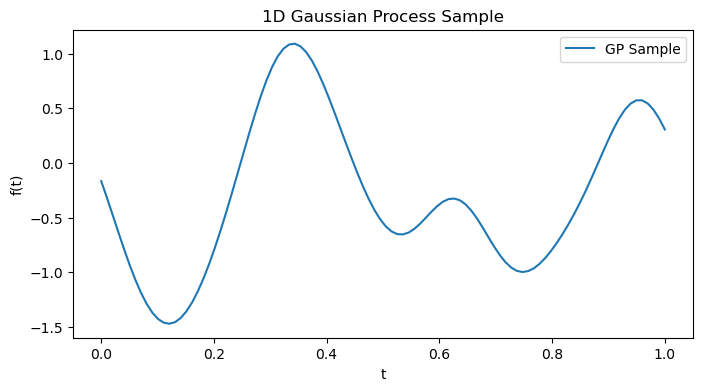

In [2]:
def generate_gp_1d(n_points=100, length_scale=0.2, sigma=1.0, random_state=None):
    """
    Generate a single 1D GP sample on [0,1].

    Parameters:
    -----------
    n_points : int
        Number of points in the 1D domain.
    length_scale : float
        RBF kernel length scale.
    sigma : float
        RBF kernel overall variance scale.
    random_state : int or None
        If set, fixes the random seed for reproducibility.

    Returns:
    --------
    t : array of shape (n_points,)
        The 1D input locations (sorted).
    f : array of shape (n_points,)
        One sample from the GP at those locations.
    """
    if random_state is not None:
        np.random.seed(random_state)

    # 1. Define the domain
    t = np.linspace(0, 1, n_points)

    # 2. Construct the covariance matrix
    K = rbf_kernel_1d(t, t, length_scale=length_scale, sigma=sigma)

    # 3. Sample from the multivariate normal distribution
    f = np.random.multivariate_normal(mean=np.zeros(n_points), cov=K)

    return t, f

# Example usage (comment/uncomment to run in a script):
if __name__ == "__main__":
    t, f_true = generate_gp_1d(n_points=100, length_scale=0.1, sigma=1.0, random_state=42)
    plt.figure(figsize=(8,4))
    plt.plot(t, f_true, label="GP Sample")
    plt.title("1D Gaussian Process Sample")
    plt.xlabel("t")
    plt.ylabel("f(t)")
    plt.legend()
    plt.show()


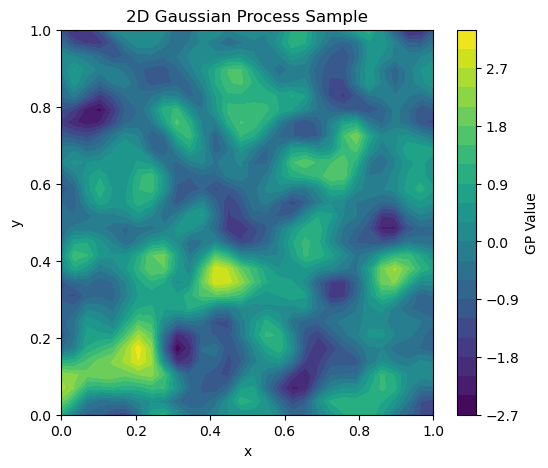

In [3]:
def generate_gp_2d(nx=30, ny=30, length_scale=0.1, sigma=1.0, random_state=None):
    """
    Generate a 2D GP sample over an (x,y) grid in [0,1]x[0,1].

    Parameters:
    -----------
    nx, ny : int
        Number of points in x and y directions.
    length_scale : float
        RBF kernel length scale in 2D.
    sigma : float
        RBF kernel overall variance scale.
    random_state : int or None

    Returns:
    --------
    X, Y : 2D arrays of shape (nx, ny)
        Meshgrid for x and y coordinates.
    F : 2D array of shape (nx, ny)
        Sampled GP values on the grid.
    """
    if random_state is not None:
        np.random.seed(random_state)

    # 1. Coordinates for each point on a 2D grid
    x = np.linspace(0, 1, nx)
    y = np.linspace(0, 1, ny)
    X, Y = np.meshgrid(x, y, indexing='ij')  # X.shape=(nx,ny), Y.shape=(nx,ny)

    # Flatten to get a list of (x_i,y_i) coords
    coords = np.column_stack((X.ravel(), Y.ravel()))  # shape (nx*ny, 2)

    # 2. Construct the covariance matrix in 2D
    K = rbf_kernel_2d(coords, coords, length_scale=length_scale, sigma=sigma)

    # 3. Sample from the multivariate normal
    F_vec = np.random.multivariate_normal(mean=np.zeros(nx*ny), cov=K)

    # 4. Reshape back to 2D
    F = F_vec.reshape(nx, ny)
    return X, Y, F

# Example usage (comment/uncomment to run in a script):
if __name__ == "__main__":
    X, Y, F_true = generate_gp_2d(nx=30, ny=30, length_scale=0.05, sigma=1.0, random_state=42)
    plt.figure(figsize=(6,5))
    plt.contourf(X, Y, F_true, levels=20, cmap='viridis')
    plt.colorbar(label="GP Value")
    plt.title("2D Gaussian Process Sample")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()


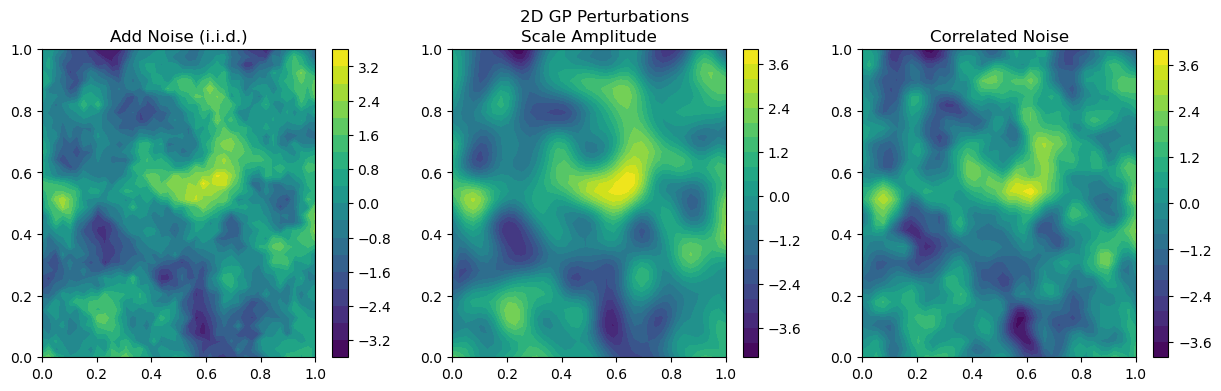

In [4]:
def add_noise_2d(F_true, noise_std=0.1):
    return F_true + np.random.normal(0, noise_std, size=F_true.shape)

def scale_amplitude_2d(F_true, scale_factor=1.1):
    return scale_factor * F_true

def correlated_noise_2d(X, Y, F_true, length_scale=0.05, sigma=0.2):
    # Flatten coords
    coords = np.column_stack((X.ravel(), Y.ravel()))
    K_noise = rbf_kernel_2d(coords, coords, length_scale=length_scale, sigma=sigma)
    noise_vec = np.random.multivariate_normal(mean=np.zeros(coords.shape[0]), cov=K_noise)
    noise_2d = noise_vec.reshape(F_true.shape)
    return F_true + noise_2d

if __name__ == "__main__":
    X, Y, F_true = generate_gp_2d(nx=40, ny=40, length_scale=0.07, sigma=1.0, random_state=2)

    F_noise = add_noise_2d(F_true, noise_std=0.3)
    F_scale = scale_amplitude_2d(F_true, scale_factor=1.3)
    F_corr  = correlated_noise_2d(X, Y, F_true, length_scale=0.03, sigma=0.5)

    # Plot a couple of them
    fig, axs = plt.subplots(1,3, figsize=(15,4))
    for ax, F, title in zip(axs, [F_noise, F_scale, F_corr],
                            ["Add Noise (i.i.d.)", "Scale Amplitude", "Correlated Noise"]):
        c = ax.contourf(X, Y, F, levels=20, cmap='viridis')
        ax.set_title(title)
        plt.colorbar(c, ax=ax)
    plt.suptitle("2D GP Perturbations")
    plt.show()
